## Libraries

In [1]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
from PIL import Image
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
# print(os.listdir("../input"))

import time

## Parameters


In [2]:
SEED=42
random.seed(SEED)
torch.manual_seed(SEED)
# Batch size during training
batch_size = 128
# Spatial size of training images. 
image_size = 64
# Number of channels 
nc = 3
# Size of z latent vector 
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 100
# different Learning rate for optimizers
g_lr = 0.0001
d_lr = 0.0004
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
ngpu=1

## CIFAR-10


In [24]:
#normalizing input between -1 and 1
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0,0,0), (1,1,1)),])


dataset = dset.CIFAR10(root='../input', train=True,
                                        download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


## Data Distribution

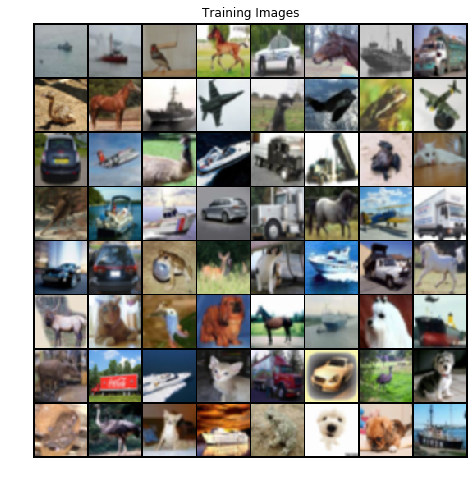

In [4]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Generator
* The architecture as given in the  [DCGAN paper](https://arxiv.org/abs/1511.06434).


![](https://pytorch.org/tutorials/_images/dcgan_generator.png)

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

The [DCGAN paper](https://arxiv.org/abs/1511.06434) mentions that that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. These are applied to each layer of Generator and Discriminator.

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Create the generator
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Discriminator

* The Discriminator is nothing but an Image classifier, that distinguishes images to be fake/real.
* It has CNNs  with leaky ReLU activations. Many activation functions will work fine with this basic GAN architecture. However, leaky ReLUs are very popular because they help the gradients flow easier through the architecture.
* Finally, it needs to output probabilities. We use a Sigmoid Activation for that.

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Both the generator and discriminator are trained on Binary Cross Entropy Loss and Adam optimizer with same learning rates are used. These parameters are kept the same as the original paper except for Label Smoothing.

In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()
# Establish convention for real and fake labels during training
# real_label = 1
# fake_label = 0
"""adding label smoothing"""
real_label=0.9
fake_label=0.1

# Setup Adam optimizers for both G and D

optimizerD = optim.Adam(netD.parameters(), lr=d_lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=g_lr, betas=(beta1, 0.999))



In [11]:
optimizerD

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.0004
    weight_decay: 0
)


### Fretchet Inception Distance


The implementation is from this amazing github repo https://github.com/mseitzer/pytorch-fid

In [12]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.torch/models/inception_v3_google-1a9a5a14.pth
108857766it [00:00, 111769450.27it/s]


In [13]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [14]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [20]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value ,mu_2

In [15]:
print("Generator Parameters:",sum(p.numel() for p in netG.parameters() if p.requires_grad))
print("Discriminator Parameters:",sum(p.numel() for p in netD.parameters() if p.requires_grad))


Generator Parameters: 3576704
Discriminator Parameters: 2765568


In [16]:
"""path="/kaggle/working/"
os.makedirs(path+"model")
os.makedirs(path+"loss")"""

In [17]:
"""mdl="/kaggle/working/model/"
os.makedirs(path+"gen")
os.makedirs(path+"gan")
os.makedirs(path+"disc")"""

Starting Training Loop...


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


accuracy_score: 0.91026  f1_score: 0.0
IS score0.2670750617980957
[10/100]	Loss_D: 1.2782	Loss_G: 0.8373	Fretchet_Distance: 118.7500


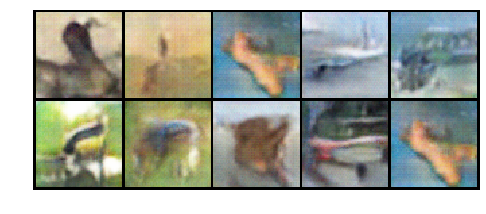

accuracy_score: 0.940434  f1_score: 0.0
IS score0.262664794921875
[20/100]	Loss_D: 1.0481	Loss_G: 2.0271	Fretchet_Distance: 115.0059


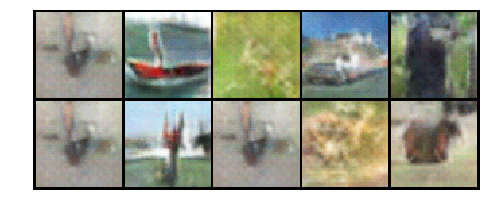

accuracy_score: 0.947144  f1_score: 0.0
IS score0.2642315924167633
[30/100]	Loss_D: 0.9357	Loss_G: 1.3456	Fretchet_Distance: 114.2366


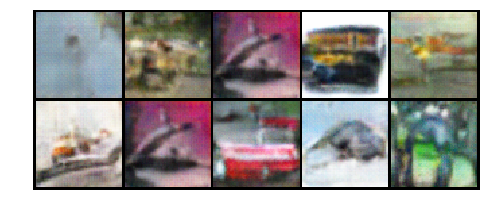

accuracy_score: 0.940778  f1_score: 0.0
IS score0.25396817922592163
[40/100]	Loss_D: 0.9092	Loss_G: 1.1167	Fretchet_Distance: 121.0015


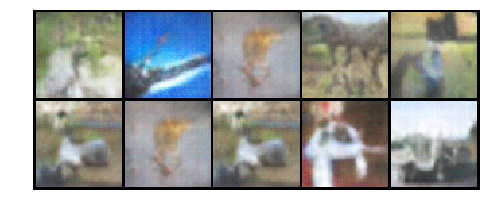

accuracy_score: 0.961622  f1_score: 0.0
IS score0.25854799151420593
[50/100]	Loss_D: 0.8504	Loss_G: 3.2450	Fretchet_Distance: 115.0635


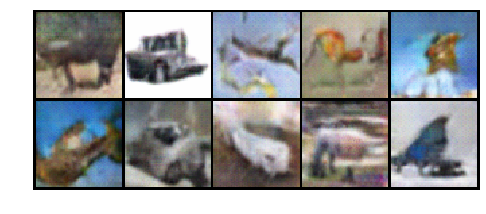

accuracy_score: 0.960168  f1_score: 0.0
IS score0.26237761974334717
[60/100]	Loss_D: 0.8223	Loss_G: 2.5649	Fretchet_Distance: 114.5535


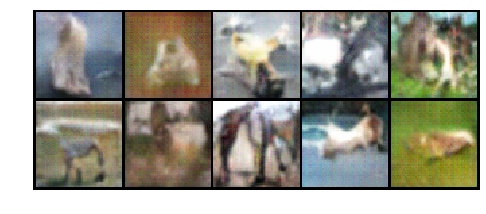

accuracy_score: 0.973428  f1_score: 0.0
IS score0.2600974440574646
[70/100]	Loss_D: 0.8144	Loss_G: 1.9748	Fretchet_Distance: 117.3591


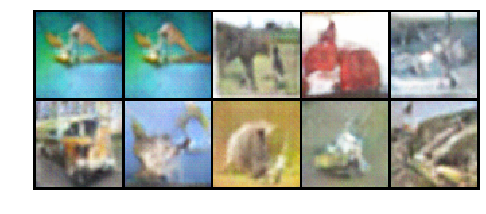

accuracy_score: 0.976778  f1_score: 0.0
IS score0.26522085070610046
[80/100]	Loss_D: 0.8059	Loss_G: 2.3856	Fretchet_Distance: 116.8388


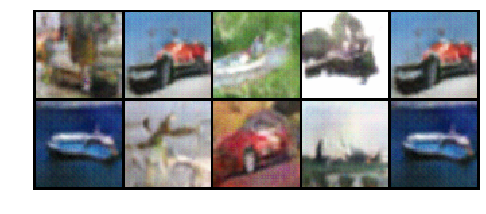

accuracy_score: 0.977468  f1_score: 0.0
IS score0.275834858417511
[90/100]	Loss_D: 0.8031	Loss_G: 2.3233	Fretchet_Distance: 115.1267


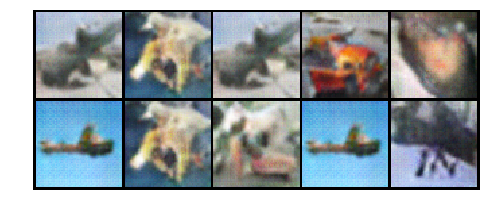

accuracy_score: 0.98523  f1_score: 0.0
IS score0.2703714966773987
[100/100]	Loss_D: 0.7933	Loss_G: 2.8442	Fretchet_Distance: 126.1656


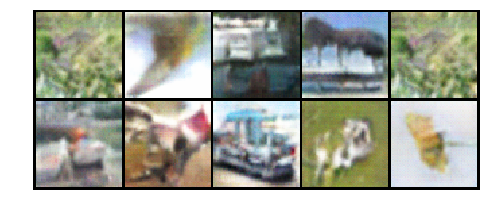

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report

img_list = []
G_losses = []
D_losses = []

iters = 0
Scores={"accuracy_score":[],
       "f1_score":[]}
preds_list=[]
label_list=[]
print("Starting Training Loop...")
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
         # add some noise to the input to discriminator
        
        real_cpu=0.9*real_cpu+0.1*torch.randn((real_cpu.size()), device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        
        label.fill_(fake_label)
        
        fake=0.9*fake+0.1*torch.randn((fake.size()), device=device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()
        
        preds=np.where(output.cpu().detach().numpy() < 0.5, 0, 1)
        
        preds_list.extend(preds)
        label_list.extend(label.cpu().detach().numpy().astype(int))
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fixed_noise = torch.randn(ngf, nz, 1, 1, device=device)
                fake_display = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_display, padding=2, normalize=True))
        iters += 1
        
   
    G_losses.append(errG.item())
    D_losses.append(errD.item())     
    fretchet_dist, IS=calculate_fretchet(real_cpu,fake,model)
    
    if ((epoch+1)%10==0):
        f1=f1_score(label_list,preds_list)
        acc=accuracy_score(label_list,preds_list)
        print(f"accuracy_score: {acc}  f1_score: {f1}")
        preds_list=[]
        label_list=[]
        Scores["accuracy_score"].append(acc)
        Scores["f1_score"].append(f1)
        print(f"IS score{np.mean(IS)}")
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tFretchet_Distance: %.4f'
                      % (epoch+1, num_epochs,
                         errD.item(), errG.item(),fretchet_dist))
        
        
        plt.figure(figsize=(8,8))
        plt.axis("off")
        pictures=vutils.make_grid(fake_display[torch.randint(len(fake_display), (10,))],nrow=5,padding=2, normalize=True)
        plt.imshow(np.transpose(pictures,(1,2,0)))
        plt.show()
torch.save(netD.state_dict(), "/kaggle/working/disc/model.pth")
torch.save(netG.state_dict(), "/kaggle/working/gen/model.pth")


In [26]:

torch.save(netG.state_dict(), "/kaggle/working/gen/model.pth")

In [ ]:
#netD=model.load_state_dict(torch.load("/kaggle/working/disc"))
#netG=model.load_state_dict(torch.load("/kaggle/working/gen"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


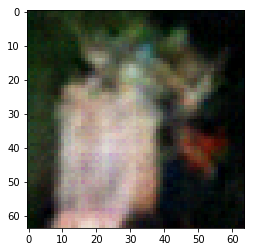

In [46]:
netG.eval()
noise = torch.randn(b_size, nz, 1, 1, device=device)
fake = netG(noise)
plt.imshow(np.transpose(fake.cpu().detach().numpy()[0], (1,2,0)))

Plotting Loss Graph

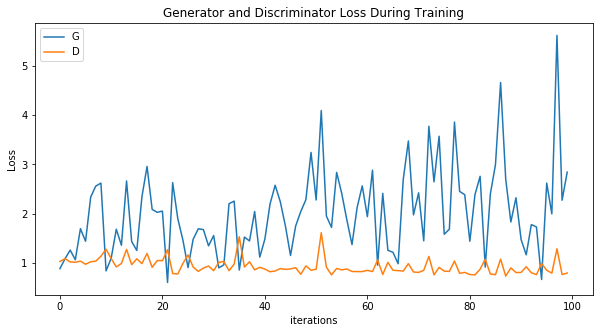

In [30]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.savefig("/kaggle/working/loss/loss_graph.png")
plt.legend()
plt.show()

Images Produced By Generator in Last Iteration

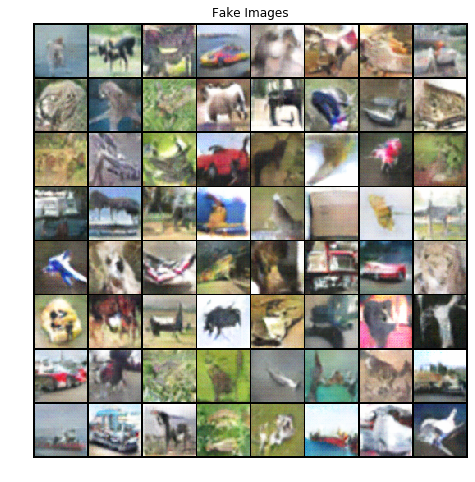

In [44]:
# Plot genearted images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig("/kaggle/working/loss/generated.png")
plt.show()


In [45]:
"""!tar -czf resimleri.tar.gz /kaggle/working/"""

tar: Removing leading `/' from member names


You can probably spot some birds, cars, trucks or dogs in the generated images.Some points I think are worth mentioning after my experiments are:-
* It's hard to converge the model properly because we have a lot of classes(10). Images belonging to different classes have very different properties which is rather tricky for a single model to learn. 
* Conditional GAN might be a good approach to implement in this case. 
* Before concluding, I would like to mention that FID is sensitive to mode collapse.As mentioned in the paper [Are GANs created Equal?](https://arxiv.org/pdf/1711.10337.pdf), the metric increases for increasing modes.

![](https://miro.medium.com/max/576/1*8PzOnrzIeuM0E1unrFKLfg.png)

## References

* https://nealjean.com/ml/frechet-inception-distance/
* https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
* https://github.com/soumith/ganhacks
* https://github.com/mseitzer/pytorch-fid
* https://medium.com/@jonathan_hui/gan-how-to-measure-gan-performance-64b988c47732

***Please upvote the kernel, if you liked it.***

I'm open to suggestions and feedback, please leave them in the comments below.